In [1]:
#This imports all the packages you need for the homework (you might not use some of them)
#Please run this first
#we will need this for array operation
import numpy as np
#we will need this for plots
import matplotlib.pyplot as plt
#We will need this to calculate factorial on array
import scipy.misc as spm
#We will need this to do calculations related to distribution
import scipy.stats as spst

#We will need this to calculate factorial on array
import scipy.special as spsp

#Sympy
import sympy 

#simpy
!pip install simpy
import simpy

xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.3 which is incompatible.
xarray 0.15.1 has requirement pandas>=0.25, but you'll have pandas 0.23.0 which is incompatible.
You are using pip version 10.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#Exercise 1 [44 Points]



##Setting

Let's imagine a small clinic with one person at the front desk and two offices. We have two types of patients.

* Type 1 patients (urgent patient) arrive following a Poisson process with $\lambda=5$ per hour.

* Type 2 patient (consultation patient) arrive following a Poisson process with $\lambda=10$ per hour.



##Q1 [10 Points]

Use two processes to seperately model the arrival processes of type 1 and type 2 customers. 


Inside the system, generate two lists:

* list one will give the arrival times of type 1 customer
* list two will give the arrival times of type 2 customer 

For this question:

* Simulate the system until T=10. Return the highest inter_arrival time among all the customer.  


* Run this simuation 1000 times, plot the distribution of the highest inter_arrival time among all the customer.  

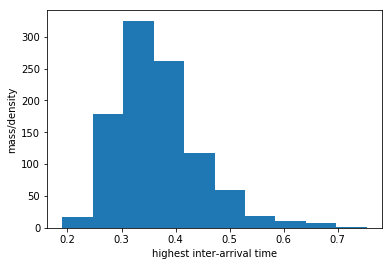

In [2]:
##Do not remove this
np.random.seed(40)

#generate the arrival process for type 1 user
def arrival1(env,arrival_times1):
    lmbda = 5
    while True:
        inter_arrival=-1/lmbda*np.log(np.random.rand())
        yield env.timeout(inter_arrival)
        arrival_times1.append(env.now)
#generate the arrival process for type 2 user
def arrival2(env,arrival_times2):
    lmbda = 10
    while True:
        inter_arrival=-1/lmbda*np.log(np.random.rand())
        yield env.timeout(inter_arrival)
        arrival_times2.append(env.now)

#construct the system function to run the arrival processes until T=10.
def system():
    env=simpy.Environment()
    arrival_times1 = []
    arrival_times2 = []
    env.process(arrival1(env, arrival_times1))
    env.process(arrival2(env, arrival_times2))
    T = 10
    env.run(until=T)
    arrival_times1 = np.array(arrival_times1)
    arrival_times2 = np.array(arrival_times2)
    arrival_times = np.sort(np.append(arrival_times1, arrival_times2))
    inter_arrivals = np.diff(np.insert(arrival_times,0,0))

    return np.max(inter_arrivals)
#run the system 1000 times and visualize the distribution of system output
max_interarrs = [system() for i in range(1000)]
plt.hist(max_interarrs)
plt.xlabel("highest inter-arrival time")
plt.ylabel("mass/density")
plt.show()


###Q2 [10 Points]


Now let's assume that when arriving, both type of patients will first register with the front desk. Here we assume that the service time is constant and is equal to 0.1. The registration follows first come first service. 

The front desk person will assign Type 1 patients to wait for office 1 and Type 2 patients to line up for office 2. Each office will follow a first come first serve order and only sees one patient at a time. The service speed in office 1 follows a uniform distribution between 0.2 and 0.4. The service speed in office 2 follows a uniform distribution between 0.1 and 0.3. 

After seeing the doctors, the patients will leave.


* Extend the system you constructed in Q1 to incorporate the new elements in the system. Instead of returning highest inter_arrival time among all the customer, give two return values. Return value 1 gives the average time in the clinic for type 1 patients. Return value 2 gives average time in the clinic for type 2 patients.

* Run the system 1000 times. Plot the distribution of the average time in the clinic for type 1 customers. Seperately, plot the distribution of the average time in the clinic for type 2 customers.


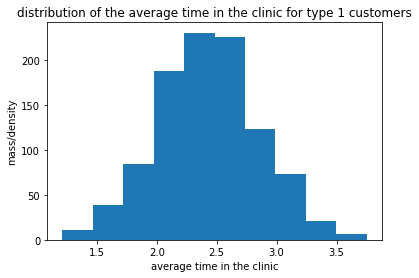

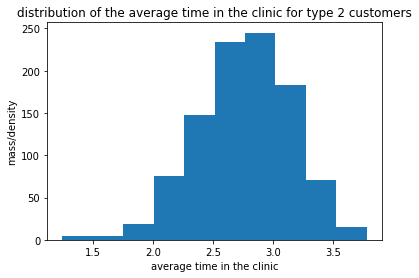

In [3]:
##Do not remove this 
np.random.seed(40)

#generate the arrival process for type 1 user
#stations[0] is the front desk, stations[1] is office 1, station[2] is office 2
def arrival1(env,arrival_times1,depart_times1, stations):
    lmbda = 5
    i = 0
    while True:
        i = i + 1
        inter_arrival=-1/lmbda*np.log(np.random.rand())
        yield env.timeout(inter_arrival)
        arrival_times1.append(env.now)
        depart_times1.append(-1)
        env.process(service1(env, arrival_times1, stations, i, depart_times1))
    
  
#generate the arrival process for type 2 user    
def arrival2(env,arrival_times2, depart_times2, stations):
    lmbda = 10
    i = 0
    while True:
        i = i + 1
        inter_arrival=-1/lmbda*np.log(np.random.rand())
        yield env.timeout(inter_arrival)
        arrival_times2.append(env.now)
        depart_times2.append(-1)
        env.process(service2(env, arrival_times2, stations, i, depart_times2))



#generate the service process for type 1 user
#i is the arrival order of this user among all type 1 users. Starting from 1
def service1(env,arrival_times1, stations, i, depart_times1 ):
    # register with the front desk
    rqt1 = stations[0].request()
    yield rqt1
    yield env.timeout(0.1)
    stations[0].release(rqt1)
    # line up for office 1
    rqt2 = stations[1].request()
    yield rqt2
    service_t = 0.2*np.random.rand()+0.2
    yield env.timeout(service_t)
    depart_times1[i-1]=env.now
    stations[1].release(rqt2)

#generate the service process for type 2 user
#i is the arrival order of this user among all type 2 users. Starting from 1
def service2(env,arrival_times2, stations,i, depart_times2):
    # register with the front desk
    rqt1 = stations[0].request()
    yield rqt1
    yield env.timeout(0.1)
    stations[0].release(rqt1)
    # line up for office 2
    rqt2 = stations[2].request()
    yield rqt2
    service_t = 0.2*np.random.rand()+0.1
    yield env.timeout(service_t)
    depart_times2[i-1]=env.now
    stations[2].release(rqt2)

#construct the system function to run the arrival processes until T=10.
#return values: (1) average time in the system for type 1 customers
#               (2) average time in the system for type 2 customers
def system():
    env=simpy.Environment()
    arrival_times1 = []
    arrival_times2 = []
    depart_times1 = []
    depart_times2 = []
    front_desk = simpy.Resource(env)
    office1 = simpy.Resource(env)
    office2 = simpy.Resource(env)
    stations=[front_desk, office1, office2]
    env.process(arrival1(env, arrival_times1, depart_times1, stations))
    env.process(arrival2(env, arrival_times2, depart_times2, stations))
    T = 10
    env.run(until=T)
    arrival_times1 = np.array(arrival_times1)
    arrival_times2 = np.array(arrival_times2)
    depart_times1 = np.array(depart_times1)
    depart_times2 = np.array(depart_times2)
    waiting_times1=depart_times1[depart_times1>0]-arrival_times1[depart_times1>0]
    waiting_times2=depart_times2[depart_times2>0]-arrival_times2[depart_times2>0]
    return np.mean(waiting_times1), np.mean(waiting_times2)
#run the system 1000 times and visualize the distribution of system output
avg_times1 = [system()[0] for i in range(1000)]
avg_times2 = [system()[1] for i in range(1000)]
plt.hist(avg_times1)
plt.title("distribution of the average time in the clinic for type 1 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()
plt.hist(avg_times2)
plt.title("distribution of the average time in the clinic for type 2 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()

##Q3 [8 Points]

Let's assume for Q2, customers might not immediately leave after seeing the doctor assigned by the front desk. Especially, let's assume that

After a type 1 patient finishes receiving the service from office 1, there are two cases:

(1) there is a 0.2 probability that this patient being immediately transferred to office 2. Transfered patients wait at the end of line. After finishing receiving the consultation with office 2, the patient is free to go.

(2) there is a 0.8 the patient is free to go directly. 

After a type 2 patient finishes receiving the service from office 2, there are two cases:

(1) there is a 0.1 probability that this patient being immediately transferred to office 1. Transfered patients wait at the end of line. After finishing receiving the consultation with office 1, the patient is free to go.

(2) there is a 0.9 the patient is free to go directly. 

* Fill in the following command cell and simulate the system 1000 times. Plot the distribution of  the average time in the clinic for type 1 customers. Seperately, plot the distribution of  the average time in the clinic for type 2 customers.

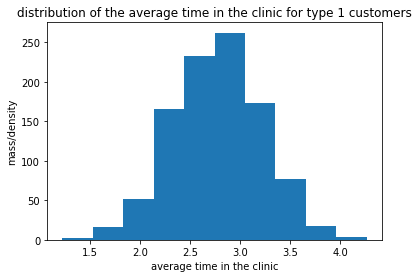

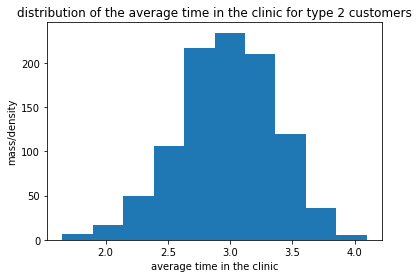

In [4]:
#generate the arrival process for type 1 user
#stations[0] is the front desk, stations[1] is office 1, station[2] is office 2
def arrival1(env,arrival_times1,depart_times1, stations):
    lmbda = 5
    i = 0
    while True:
        i = i + 1
        inter_arrival=-1/lmbda*np.log(np.random.rand())
        yield env.timeout(inter_arrival)
        arrival_times1.append(env.now)
        depart_times1.append(-1)
        env.process(service1_updated(env, arrival_times1, stations, i, depart_times1))
    
  
#generate the arrival process for type 2 user    
def arrival2(env,arrival_times2, depart_times2, stations):
    lmbda = 10
    i = 0
    while True:
        i = i + 1
        inter_arrival=-1/lmbda*np.log(np.random.rand())
        yield env.timeout(inter_arrival)
        arrival_times2.append(env.now)
        depart_times2.append(-1)
        env.process(service2_updated(env, arrival_times2, stations, i, depart_times2))

#generate the updated service process for type 1 user 
def service1_updated(env,arrival_times1, stations, i, depart_times1 ):
    # register with the front desk
    rqt1 = stations[0].request()
    yield rqt1
    yield env.timeout(0.1)
    stations[0].release(rqt1)
    # line up for office 1
    rqt2 = stations[1].request()
    yield rqt2
    service_t1 = 0.2*np.random.rand()+0.2
    yield env.timeout(service_t1)
    #depart_times1[i-1]=env.now
    stations[1].release(rqt2)     
    if (np.random.rand()>0.8):
        rqt3 = stations[2].request()
        yield rqt3
        service_t2 = 0.2*np.random.rand()+0.1
        yield env.timeout(service_t2)
        depart_times1[i-1]=env.now
        stations[2].release(rqt3)
    else:
        depart_times1[i-1]=env.now

#generate the updated service process for type 2 user
def service2_updated(env,arrival_times2, stations, i, depart_times2 ):
    #register with the front desk
    rqt1 = stations[0].request()
    yield rqt1
    yield env.timeout(0.1)
    stations[0].release(rqt1)
    # line up for office 2
    rqt2 = stations[2].request()
    yield rqt2
    service_t1 = 0.2*np.random.rand()+0.1
    yield env.timeout(service_t1)
    #depart_times2[i-1]=env.now
    stations[2].release(rqt2)
    if (np.random.rand()>0.9):
        rqt3 = stations[1].request()
        yield rqt3
        service_t2 = 0.2*np.random.rand()+0.2
        yield env.timeout(service_t2)
        depart_times2[i-1]=env.now
        stations[1].release(rqt3)
    else:
        depart_times2[i-1]=env.now

#construct the system function to run the arrival processes until T=10.
def system():
    env=simpy.Environment()
    arrival_times1 = []
    arrival_times2 = []
    depart_times1 = []
    depart_times2 = []
    front_desk = simpy.Resource(env)
    office1 = simpy.Resource(env)
    office2 = simpy.Resource(env)
    stations=[front_desk, office1, office2]
    env.process(arrival1(env, arrival_times1, depart_times1, stations))
    env.process(arrival2(env, arrival_times2, depart_times2, stations))
    T = 10
    env.run(until=T)
    arrival_times1 = np.array(arrival_times1)
    arrival_times2 = np.array(arrival_times2)
    depart_times1 = np.array(depart_times1)
    depart_times2 = np.array(depart_times2)
    waiting_times1=depart_times1[depart_times1>0]-arrival_times1[depart_times1>0]
    waiting_times2=depart_times2[depart_times2>0]-arrival_times2[depart_times2>0]
    return np.mean(waiting_times1), np.mean(waiting_times2)

#run the system 1000 times and visualize the distribution of system output
avg_times1 = [system()[0] for i in range(1000)]
avg_times2 = [system()[1] for i in range(1000)]
plt.hist(avg_times1)
plt.title("distribution of the average time in the clinic for type 1 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()
plt.hist(avg_times2)
plt.title("distribution of the average time in the clinic for type 2 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()

## Q4. [8 Points]

Now assume that for the system we constructed in Q3, there can be a probability for a Type 2 patient to renege. Especially, for every Type 2 patient, if after lining up for the front desk for t=0.4 there are still more than 3 people (not including the person currently receiving the service) waiting to receive the server from the front desk, the patient will leave.

Again, simulate the system for 1000 times. Plot the distribution of the average time in the clinic for type 1 customers. Seperately, plot the distribution of  the average time in the clinic for type 2 customers.

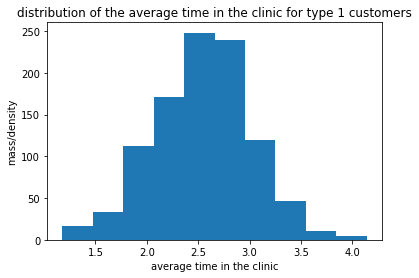

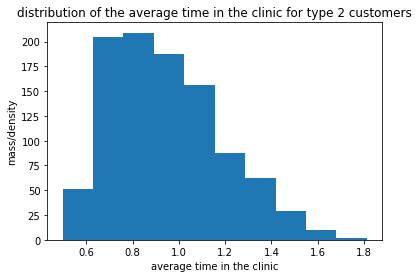

In [6]:
#generate the arrival process for type 2 user    
def arrival2_q4(env,arrival_times2, depart_times2, stations):
    lmbda = 10
    i = 0
    while True:
        i = i + 1
        inter_arrival=-1/lmbda*np.log(np.random.rand())
        yield env.timeout(inter_arrival)
        arrival_times2.append(env.now)
        depart_times2.append(-1)
        env.process(service2_q4(env, arrival_times2, stations, i, depart_times2))

#only include the functions you need to modify from Q1-Q3
def service2_q4(env,arrival_times2, stations, i, depart_times2 ):
    #register with the front desk
    rqt1 = stations[0].request()
    result=yield rqt1 | env.timeout(0.4)
    # if customer i doesn't renege
    if rqt1 in result:
        yield env.timeout(0.1)
        stations[0].release(rqt1)
        # line up for office 2
        rqt2 = stations[2].request()
        yield rqt2
        service_t1 = 0.2*np.random.rand()+0.1
        yield env.timeout(service_t1)
        stations[2].release(rqt2)
        if (np.random.rand()>0.9):
            rqt3 = stations[1].request()
            yield rqt3
            service_t2 = 0.2*np.random.rand()+0.2
            yield env.timeout(service_t2)
            depart_times2[i-1]=env.now
            stations[1].release(rqt3)
        else:
            depart_times2[i-1]=env.now
    # if customer i regenes
    else:
        #leave the queue
        if len(stations[0].queue) > 3:
            rqt1.cancel()
            depart_times2[i-1]=env.now
        #keep waiting since I am almost there
        else:
            yield rqt1
            yield env.timeout(0.1)
            stations[0].release(rqt1)
            # line up for office 2
            rqt2 = stations[2].request()
            yield rqt2
            service_t1 = 0.2*np.random.rand()+0.1
            yield env.timeout(service_t1)
            stations[2].release(rqt2)
            if (np.random.rand()>0.9):
                rqt3 = stations[1].request()
                yield rqt3
                service_t2 = 0.2*np.random.rand()+0.2
                yield env.timeout(service_t2)
                depart_times2[i-1]=env.now
                stations[1].release(rqt3)
            else:
                depart_times2[i-1]=env.now

#construct the system function to run the arrival processes until T=10.
def system():
    env=simpy.Environment()
    arrival_times1 = []
    arrival_times2 = []
    depart_times1 = []
    depart_times2 = []
    front_desk = simpy.Resource(env)
    office1 = simpy.Resource(env)
    office2 = simpy.Resource(env)
    stations=[front_desk, office1, office2]
    env.process(arrival1(env, arrival_times1, depart_times1, stations))
    env.process(arrival2_q4(env, arrival_times2, depart_times2, stations))
    T = 10
    env.run(until=T)
    arrival_times1 = np.array(arrival_times1)
    arrival_times2 = np.array(arrival_times2)
    depart_times1 = np.array(depart_times1)
    depart_times2 = np.array(depart_times2)
    waiting_times1=depart_times1[depart_times1>0]-arrival_times1[depart_times1>0]
    waiting_times2=depart_times2[depart_times2>0]-arrival_times2[depart_times2>0]
    return np.mean(waiting_times1), np.mean(waiting_times2)

#run the system 1000 times and visualize the distribution of system output
avg_times1 = [system()[0] for i in range(1000)]
avg_times2 = [system()[1] for i in range(1000)]
plt.hist(avg_times1)
plt.title("distribution of the average time in the clinic for type 1 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()
plt.hist(avg_times2)
plt.title("distribution of the average time in the clinic for type 2 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()

##Q5 [8 Points]

Now, the clinic is thinking about adding office 3. There are two possiblities. 

(1) Proposal 1: Have this office work as a parallel office of office 1. In this case, customers orgianlly waiting to receive the service from office will now wait in one line and receive the service from either office 1 or office 3, depending on which one becomes available first. In this case, the service speed for office 3 will follow the same distribution as the distribution of the service speed of office 1.

(2) Proposal 2: Have this office work as a parallel office of office 2. In this case, customers orgianlly waiting to receive the service from office will now wait in one line and receive the service from either office 2 or office 3, depending on which one becomes available first. In this case, the service speed for office 3 will follow the same distribution as the distribution of the service speed of office 2.



Motify your code from before. For each case, provide the plots you showed. (You will show 4 plots)


Following simulating the system for 1000 times, discuss which case is better based on the following metrics:

* Mean of maximum waiting time for all customers
* Mean of average waiting time for all customers
* Mean of difference of average waiting time between two consumer types.


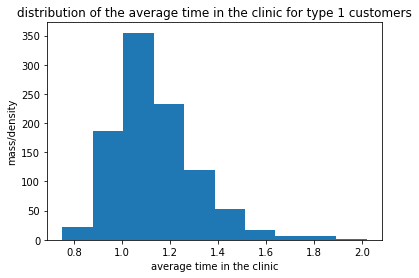

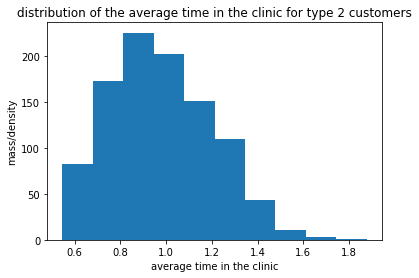

In [7]:
#Proposal 1

#only include the functions you need to modify from Q1-Q4

# stations[1] will be a resource of capacity 2 representing office 1 and 3 altogether 
def system1():
    env=simpy.Environment()
    arrival_times1 = []
    arrival_times2 = []
    depart_times1 = []
    depart_times2 = []
    front_desk = simpy.Resource(env)
    office_1_3 = simpy.Resource(env, capacity=2)
    office2 = simpy.Resource(env)
    stations=[front_desk, office_1_3, office2]
    env.process(arrival1(env, arrival_times1, depart_times1, stations))
    env.process(arrival2_q4(env, arrival_times2, depart_times2, stations))
    T = 10
    env.run(until=T)
    arrival_times1 = np.array(arrival_times1)
    arrival_times2 = np.array(arrival_times2)
    depart_times1 = np.array(depart_times1)
    depart_times2 = np.array(depart_times2)
    waiting_times1=depart_times1[depart_times1>0]-arrival_times1[depart_times1>0]
    waiting_times2=depart_times2[depart_times2>0]-arrival_times2[depart_times2>0]
    waiting_times = np.append(waiting_times1, waiting_times2)
    return np.mean(waiting_times1), np.mean(waiting_times2), np.max(waiting_times),\
     np.mean(waiting_times), np.mean(waiting_times1)-np.mean(waiting_times2)

avg_times1 = [system1()[0] for i in range(1000)]
avg_times2 = [system1()[1] for i in range(1000)]
plt.hist(avg_times1)
plt.title("distribution of the average time in the clinic for type 1 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()
plt.hist(avg_times2)
plt.title("distribution of the average time in the clinic for type 2 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()

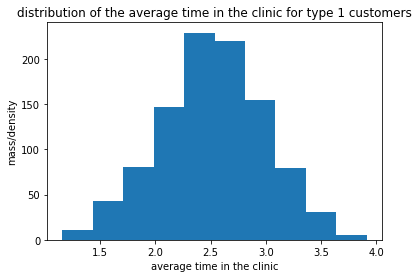

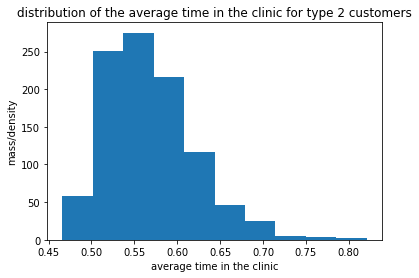

In [8]:
#Proposal 2

#only include the functions you need to modify from Q1-Q4
# stations[2] will be a resource of capacity 2 representing office 2 and 3 altogether 
def system2():
    env=simpy.Environment()
    arrival_times1 = []
    arrival_times2 = []
    depart_times1 = []
    depart_times2 = []
    front_desk = simpy.Resource(env)
    office1 = simpy.Resource(env)
    office_2_3 = simpy.Resource(env, capacity=2)
    stations=[front_desk, office1, office_2_3]
    env.process(arrival1(env, arrival_times1, depart_times1, stations))
    env.process(arrival2_q4(env, arrival_times2, depart_times2, stations))
    T = 10
    env.run(until=T)
    arrival_times1 = np.array(arrival_times1)
    arrival_times2 = np.array(arrival_times2)
    depart_times1 = np.array(depart_times1)
    depart_times2 = np.array(depart_times2)
    waiting_times1=depart_times1[depart_times1>0]-arrival_times1[depart_times1>0]
    waiting_times2=depart_times2[depart_times2>0]-arrival_times2[depart_times2>0]
    waiting_times = np.append(waiting_times1, waiting_times2)
    return np.mean(waiting_times1), np.mean(waiting_times2), np.max(waiting_times),\
     np.mean(waiting_times), np.mean(waiting_times1)-np.mean(waiting_times2)

avg_times1 = [system2()[0] for i in range(1000)]
avg_times2 = [system2()[1] for i in range(1000)]
plt.hist(avg_times1)
plt.title("distribution of the average time in the clinic for type 1 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()
plt.hist(avg_times2)
plt.title("distribution of the average time in the clinic for type 2 customers")
plt.xlabel("average time in the clinic")
plt.ylabel("mass/density")
plt.show()

In [9]:
#Policy comparison

# Policy 1
max_waiting_times1 = []
avg_waiting_times1 = []
diff_awt_1 = []
for i in range(1000):
    tup1 = system1()
    max_waiting_times1.append(tup1[2])
    avg_waiting_times1.append(tup1[3])
    diff_awt_1.append(tup1[4])

max_waiting_times1 = np.array(max_waiting_times1)
avg_waiting_times1 = np.array(avg_waiting_times1)
diff_awt_1 = np.array(diff_awt_1)

print("For policy 1, the mean of maximum waiting time for all patients is", np.mean(max_waiting_times1))
print("For policy 1, the mean of average waiting time for all patients is", np.mean(avg_waiting_times1))
print("For policy 1, the mean of difference of average waiting time between two patient types \
is", np.mean(diff_awt_1))

# Policy 2
max_waiting_times2 = []
avg_waiting_times2 = []
diff_awt_2 = []
for i in range(1000):
    tup2 = system2()
    max_waiting_times2.append(tup2[2])
    avg_waiting_times2.append(tup2[3])
    diff_awt_2.append(tup2[4])

max_waiting_times2 = np.array(max_waiting_times2)
avg_waiting_times2 = np.array(avg_waiting_times2)
diff_awt_2 = np.array(diff_awt_2)
print("\n")
print("For policy 2, the mean of maximum waiting time for all patients is", np.mean(max_waiting_times2))
print("For policy 2, the mean of average waiting time for all patients is", np.mean(avg_waiting_times2))
print("For policy 2, the mean of difference of average waiting time between two patient types \
is", np.mean(diff_awt_2))

For policy 1, the mean of maximum waiting time for all patients is 3.0680697040819376
For policy 1, the mean of average waiting time for all patients is 1.0467108401029293
For policy 1, the mean of difference of average waiting time between two patient types is 0.1326371991004113


For policy 2, the mean of maximum waiting time for all patients is 4.366492457184023
For policy 2, the mean of average waiting time for all patients is 1.0195205378856544
For policy 2, the mean of difference of average waiting time between two patient types is 1.9293532119259644


I think policy 1 is better even though policy 2 has a bit lower average waiting time for all patients. Policy 1 gives a much lower maximum waiting time for any patient. This means no patient will need to wait for a very long time on average. Also, policy 1 treats two types of patients relatively equally because the mean of difference of average waiting time between two types of patients is much lower for policy 1. This is good because type 1 patients(urgent patients) should not wait for too long as they need service very urgently. It makes sense to provide more resource to type 1 patients.

##Exercise 2 [16 Points]





An insurance company has 500 customers. The insurance company is interested in studying how long it takes for 400 customers of these 500 customers to churn (stop being a customer) and how much profit could be generated from all of the customer at that point.

* The company wants to assume that for each customer, the time it takes for the customer to discontinue the service since the starting point of our simulation follows an exponential distribution with $λ_l={1}$. 

* During their stay, the inter-arrival time of the claims for a single customer follows an exponential distribution with $λ_c=0.01$. The amount of claim follows a uniform distribution between 10 and 100.

* The revenue we generete from the customer depends on the length of stay. If the customer stayed with the company for t periods of time, the amount of revenue generated is t. When a customer churns, the company stops generating revenue from this customer.

* The total profit is equal to the total revenue minus the total claim amount




Based on the setting:

* Simulate the system until we have only 100 customers left. Compute how much profit is generated from these customers. 

* Repeat the simulation 500 times. plot the distribution of the revenue and distribution of the time it takes to lose 400 customers.

In [10]:
def churns(env, inter_arr, times_until_churned, vals_400):
  
    i=0
    while (i<400):
        inter_arrival = inter_arr[i]
        yield env.timeout(inter_arrival)
        i = i+1
        env.process(claims(env, times_until_churned, vals_400 ,i))

def claims(env, times_until_churned, vals_400, i):
    # how long the customer i stays in the service
    time = times_until_churned[i-1]
    # arrivals of claims for customer i
    now = env.now
    while ((env.now-now) <= time):
        int_arr = -100*np.log(np.random.rand())
        yield env.timeout(int_arr)
        if ((env.now - now) <= time):
            vals_400.append(90*np.random.rand()+10)


def system_e2():
    # sample the times in service for all 500 customers
    times_in_service = np.sort(-np.log(np.random.rand(500)))
    # how long do we actually simulate
    T = times_in_service[399]
    # The simulation time is exactly the time in service
    # of the customer who is the 400th to discontinue the service.
    times_in_service[400:] = T
    # The total amount of revenue is simply the sum of all times in service until our simulation ends
    total_revenue = np.sum(times_in_service)
    # Let's separately deal with the 400 churned customers and the 100 remaining customers

    # Let's deal with the 100 remaining customers first as their times in service
    # are all equal to T. We know the arrivals of claims for a single customer follows 
    # a poisson process with lambda = 0.01

    # Numbers of arrived claims for the 100 remaining customers
    Nums_claims = np.random.poisson(0.01*T, 100)
    # Total number of claims for the 100 customers
    T_Num_claims = np.sum(Nums_claims)
    # Total value of the claims for the 100 customers
    Val_claims_100=np.sum(90*np.random.rand(T_Num_claims)+10)
    # Then let's deal with the 400 churned customers
    times_until_churned = times_in_service[0:400]
    inter_arr = np.diff(np.insert(times_until_churned,0,0))
    # We need to use simpy processes to model the 400 churned customers
    vals_400 = []
    env = simpy.Environment()
    env.process(churns(env, inter_arr, times_until_churned, vals_400))
    env.run()
    profit = total_revenue - (Val_claims_100 + np.sum(vals_400))
    return profit, T

print("Amount of profit generated from these customers is", system_e2()[0])

Amount of profit generated from these customers is 354.3204664452818


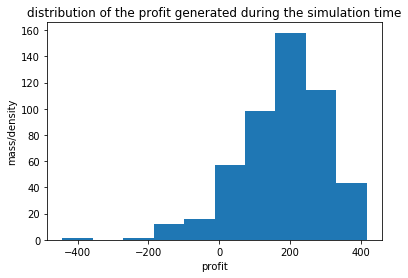

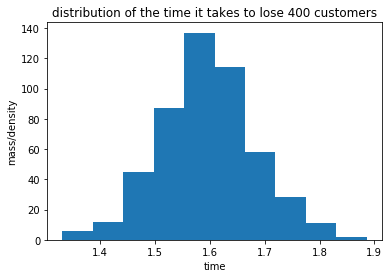

In [11]:
profits = [system_e2()[0] for i in range(500)]
T_400 = [system_e2()[1] for i in range(500)]
plt.hist(profits)
plt.title("distribution of the profit generated during the simulation time")
plt.xlabel("profit")
plt.ylabel("mass/density")
plt.show()
plt.hist(T_400)
plt.title("distribution of the time it takes to lose 400 customers")
plt.xlabel("time")
plt.ylabel("mass/density")
plt.show()